### Mean Reversion Strategy

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import back_testing as bt

In [14]:
def fetch_stock_data(ticker, startdate, enddate):
    data = yf.download(ticker, start = startdate, end = enddate)
    data = data.reset_index()

    #remove ticker multiindex
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)

    #rename columns
    data = data.rename(columns= {'Date': 'date', "Open": "open", "Close": "close", "High": "high", "Low": "low", "Volume": "volume"})
    return data

In [15]:
def generate_signals(data):
    import pandas as pd
    bollinger_period = 20
    data["sma_20"] = data["close"].rolling(bollinger_period).mean()
    data["stdev_20"] = data["close"].rolling(bollinger_period).std()

    # Bollinger bands
    data["upper_bollinger"] = data["sma_20"] + 2 * data["stdev_20"]
    data["lower_bollinger"] = data["sma_20"] - 2 * data["stdev_20"]

    # RSI
    rsi_period = 6
    data["delta"] = data["close"].diff()
    data["gain"] = data["delta"].clip(lower=0)
    data["loss"] = data["delta"].clip(upper=0) * -1
    data["avg_gain"] = data["gain"].ewm(rsi_period).mean()
    data["avg_loss"] = data["loss"].ewm(rsi_period).mean()
    data["rsi_index"] = 100 - (100 / (1 + data["avg_gain"] / data["avg_loss"]))


    # Signals
    data["signal"] = 0

    long_condition = (data["rsi_index"] < 30) & (data["close"] < data["lower_bollinger"])
    short_condition = (data["rsi_index"] > 70) & (data["close"] > data["upper_bollinger"])

    data.loc[long_condition, "signal"] = 1
    data.loc[short_condition, "signal"] = -1

    data.loc[data["sma_20"].isna(), "signal"] = 0
    data.loc[data["rsi_index"].isna(), "signal"] = 0

    return data

In [16]:
#fetching data
ticker = "XYZ"
data = fetch_stock_data(ticker, "2019-01-01", "2021-06-01")

C:\Users\Matthew S\AppData\Local\Temp\ipykernel_29428\3611022379.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = startdate, end = enddate)
[*********************100%***********************]  1 of 1 completed

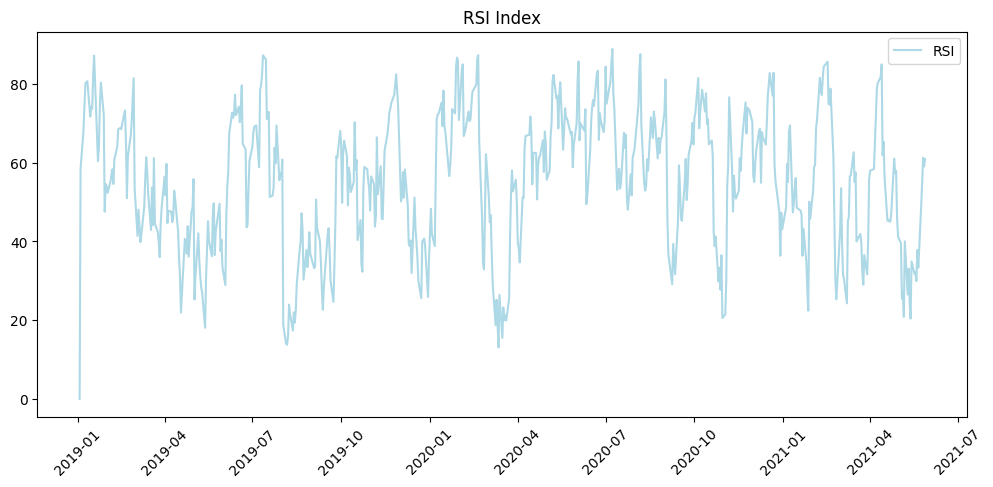

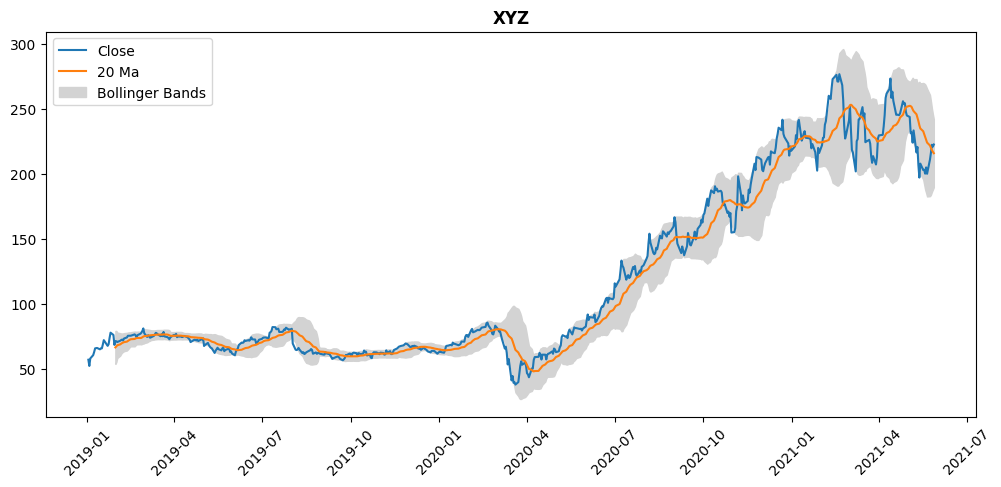

In [17]:
# Generate signals

data = generate_signals(data)

# Plot RSI
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)
plt.plot(data["date"], data["rsi_index"], label='RSI', color='lightblue')
plt.title('RSI Index')
plt.legend()
plt.show()

# Plot MA & bollinger bands
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

plt.plot(data['date'], data['close'], label = 'Close')
plt.plot(data['date'], data['sma_20'], label = '20 Ma')
plt.fill_between(data['date'], data['upper_bollinger'], data['lower_bollinger'], label = 'Bollinger Bands', color='lightgrey')
plt.title(ticker, fontweight = 'bold')

plt.legend()        
plt.show()

In [18]:
#backtesting

bt.backtest_strategy(data)


Evaluation Metrics:
-----------------------------------

Gains: 42
Losses: 29
Win Rate: 0.5915492957746479
Stock return: 3.890
Strategy returns: 1.085
Sharpe Ratio: 0.079


Price,date,close,high,low,open,volume,sma_20,stdev_20,upper_bollinger,lower_bollinger,...,loss,avg_gain,avg_loss,rsi_index,signal,position,return,cumulative_return,strategy,cumulative_strategy
0,2019-01-02,57.200001,57.830002,53.560001,54.099998,13434000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,52.419998,56.730000,52.259998,55.580002,19076300,NaN,NaN,NaN,NaN,...,4.780003,0.000000,4.780003,0.000000,0,0.0,-0.083566,0.916434,-0.0,1.00000
2,2019-01-04,58.180000,59.660000,53.861000,54.400002,30228600,NaN,NaN,NaN,NaN,...,-0.000000,3.101540,2.206155,58.434778,0,0.0,0.109882,1.017133,0.0,1.00000
3,2019-01-07,60.720001,61.290001,58.049999,59.000000,18146900,NaN,NaN,NaN,NaN,...,-0.000000,2.884883,1.354961,68.042191,0,0.0,0.043658,1.061538,0.0,1.00000
4,2019-01-08,63.119999,63.799999,61.150002,62.599998,21511800,NaN,NaN,NaN,NaN,...,-0.000000,2.734371,0.934372,74.531559,0,0.0,0.039526,1.103496,0.0,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,2021-05-24,210.949997,212.800003,197.300003,202.169998,13215000,221.770499,19.463555,260.697610,182.843389,...,-0.000000,3.249721,3.372666,49.071748,0,0.0,0.054697,3.687937,0.0,1.08475
603,2021-05-25,216.199997,219.089996,211.770004,212.070007,14779000,219.891000,17.966199,255.823398,183.958601,...,-0.000000,3.535476,2.890857,55.015447,0,0.0,0.024887,3.779720,0.0,1.08475
604,2021-05-26,222.339996,223.830002,215.800003,218.039993,11914400,218.298000,16.077181,250.452361,186.143638,...,-0.000000,3.907550,2.477877,61.194810,0,0.0,0.028400,3.887063,0.0,1.08475
605,2021-05-27,220.899994,223.389999,217.660004,222.380005,8555700,216.955000,14.534401,246.023801,187.886198,...,1.440002,3.349329,2.329610,58.978081,0,0.0,-0.006477,3.861888,-0.0,1.08475


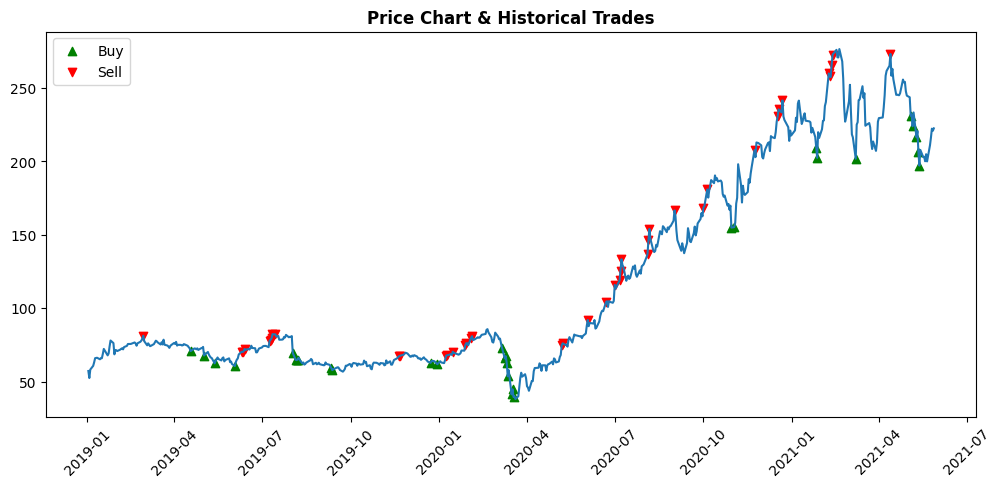

In [ ]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

plt.plot(data['date'], data['close'])
plt.scatter(data[(data['position'] == 1)]['date'], data[(data['position'] == 1)]['close'], label = 'Buy', marker='^', c='g')
plt.scatter(data[(data['position'] == -1)]['date'], data[(data['position'] == -1)]['close'], label = 'Sell', marker='v', c='r')

plt.title('Price Chart & Historical Trades', fontweight="bold")
plt.legend()
plt.show()